In [1]:
# to print all outputs in a cell instead of just the last one 
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = 'all'  # 'last_expr'  

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = 16, 10
#%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

# we will not use profiling as number of features is too high and output is too lengthy
# import pandas_profiling as pp

# to display all columns of DF
pd.set_option('display.max_columns', None)

In [2]:
#read the dataset
data_train = pd.read_csv('./input/train.csv', index_col='Id')
data_submission = pd.read_csv('./input/test.csv', index_col='Id')

# Exploratory Data Analysis

## Description of the dataset

In [3]:
print('Dataset = {:d} observations x {:d} features (including target)'.format(data_train.shape[0], data_train.shape[1]))
data_train.sample(5)

Dataset = 1460 observations x 80 features (including target)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
561,20,RL,NaN,11341,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1957,1996,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,Gd,TA,No,ALQ,1302,Unf,0,90,1392,GasA,TA,Y,SBrkr,1392,0,0,1392,1,0,1,1,3,1,TA,5,Mod,1,Gd,Detchd,1957.0,Unf,2,528,TA,TA,Y,0,0,0,0,95,0,NaN,NaN,NaN,0,5,2010,WD,Normal,121500
1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,Ex,Y,SBrkr,1831,1796,0,3627,1,0,3,1,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
207,20,RL,40.0,13673,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,1Story,5,5,1962,1962,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,CBlock,TA,TA,No,Unf,0,Unf,0,1140,1140,GasA,TA,Y,SBrkr,1696,0,0,1696,0,0,1,1,3,1,TA,8,Min2,1,TA,Attchd,1962.0,RFn,1,349,TA,TA,Y,0,30,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,143900
991,60,RL,82.0,9452,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,423.0,Gd,TA,PConc,Gd,TA,No,GLQ,1074,Unf,0,322,1396,GasA,Ex,Y,SBrkr,1407,985,0,2392,1,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,1997.0,Fin,3,870,TA,TA,Y,0,70,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,348000
502,60,FV,75.0,9803,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,400,Unf,0,466,866,GasA,Gd,Y,SBrkr,866,902,0,1768,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2005.0,RFn,2,603,TA,TA,Y,0,108,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,226700


In [4]:
# computing basic statistics 
summary = pd.DataFrame(np.array([data_train.dtypes, 
                                 data_train.isnull().sum(), 
                                 data_train.isnull().sum() / data_train.shape[0] * 100, 
                                 data_train.nunique()]),
                       index=['Dtype', 'NullValuesCount', 'NullValuesPct', 'NbrUniqVal'],
                       columns=np.array(list(data_train)))

display(summary)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Dtype,int64,object,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,object,object,object,object,object,float64,object,object,object,object,object,object,object,int64,object,int64,int64,int64,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,object,int64,object,object,float64,object,int64,int64,object,object,object,int64,int64,int64,int64,int64,int64,object,object,object,int64,int64,int64,object,object,int64
NullValuesCount,0,0,259,0,0,1369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,37,37,38,37,0,38,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,690,81,81,81,0,0,81,81,0,0,0,0,0,0,0,1453,1179,1406,0,0,0,0,0,0
NullValuesPct,0,0,17.7397,0,0,93.7671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.547945,0.547945,0,0,0,2.53425,2.53425,2.60274,2.53425,0,2.60274,0,0,0,0,0,0,0.0684932,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47.2603,5.54795,5.54795,5.54795,0,0,5.54795,5.54795,0,0,0,0,0,0,0,99.5205,80.7534,96.3014,0,0,0,0,0,0
NbrUniqVal,15,5,110,1073,2,2,4,4,2,5,3,25,9,8,5,8,10,9,112,61,6,8,15,16,4,327,4,5,6,4,4,4,6,637,6,144,780,721,6,5,2,5,753,417,24,861,4,3,4,3,8,4,4,12,7,4,5,6,97,3,5,441,5,5,3,274,202,120,20,76,8,3,4,4,21,12,5,9,6,663


### Removing outliers
The link in the Acknowledgments section of [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques "House Prices: Advanced Regression Techniques") web site contains the following information on the dataset:  
*There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.*  
I followed this advice and removed observations with *GrLivArea* above 4000. 

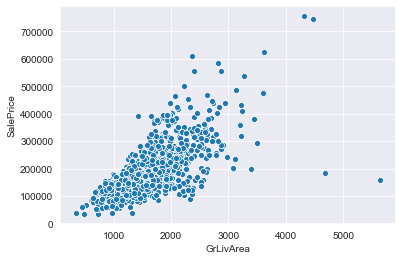

In [5]:
sns.scatterplot(x=data_train.GrLivArea, y=data_train.SalePrice);
data_train = data_train[data_train.GrLivArea < 4000]

## Transforming the target
We see that the target variable is positively skewed.  
We use a **log transform to remove skew and normalize the target variable**. This is also more in accordance with a multiplicative model (ie a model where a given feature add x% to the price rather than a constant sum y USD)

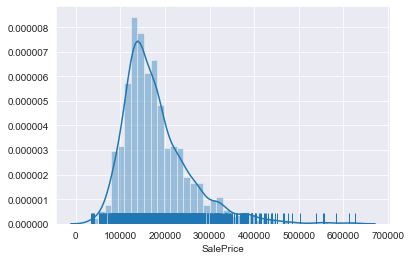

In [6]:
sns.distplot(data_train.SalePrice, rug=True);

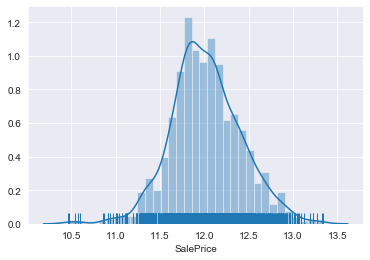

In [7]:
sns.distplot(np.log(data_train.SalePrice), rug=True);

# TODO remove here
MiscVal is containing the value of miscalleneous feature. This is an additive factor, so we **subtract MiscVal before applying the log transform**. And we discard the 2 columns MiscFeature and MiscVal from the list of independent variables that we will include in our model.  

In [8]:
#data_FE = data_train.copy()
#data_FE['y_FE'] = np.log(data_FE.SalePrice - data_FE.MiscVal)

#features_drop = ['MiscFeature', 'MiscVal']
#data_FE.drop(features_drop + ['SalePrice'], axis=1, inplace=True)

## Numerical features

In [9]:
train_numeric = data_train.select_dtypes(include=[np.number])
print('Total of numerical plus ordinal features (including target) = {:d}'.format(train_numeric.shape[1]))
train_numeric.sample(5)

features_cont = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                '3SsnPorch', 'ScreenPorch', 'PoolArea']
features_disc = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']
features_time = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
features_ord = ['OverallQual', 'OverallCond']
features_nom = ['MSSubClass']
label = ['SalePrice']
#print('Numerical values:') 
#print('   {:d} continuous features (or considered as continuous)'.format(len(features_cont)))
#print('   {:d} discrete features (ie count)'.format(len(features_disc)))
#print('   {:d} time features (ie year or month)'.format(len(features_time)))
#print('   {:d} ordinal features'.format(len(features_ord)))
#print('   + 2 others: MSSubClass, and the label')

Total of numerical plus ordinal features (including target) = 37


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
154,20,NaN,13500,6,7,1960,1975,0.0,429,1080,93,1602,1252,0,0,1252,1,0,1,0,1,1,4,1,1960.0,2,564,409,0,0,0,0,0,0,3,2008,235000
567,60,77.0,11198,9,5,2005,2007,245.0,0,0,1122,1122,1134,1370,0,2504,0,0,2,1,4,1,11,1,2005.0,3,656,144,39,0,0,0,0,0,6,2008,325000
1450,180,21.0,1533,5,7,1970,1970,0.0,553,0,77,630,630,0,0,630,1,0,1,0,1,1,3,0,NaN,0,0,0,0,0,0,0,0,0,8,2006,92000
1390,50,60.0,6000,6,6,1941,1950,0.0,375,0,360,735,869,349,0,1218,0,1,1,0,3,1,6,1,2003.0,2,440,0,0,0,0,0,0,0,3,2007,131000
290,70,60.0,8730,6,7,1915,2003,0.0,0,0,698,698,698,698,0,1396,0,0,1,0,3,1,7,0,2003.0,1,384,0,0,0,0,259,0,0,7,2007,153575


### Correlation with target
I plot first correlation of continuous features with the target and the log of the target.  
Both exhibit the same level of correlation with the features.  
Features showing the highest corelation are *GrLivArea* (0.72), *TotalBsmtSF*, *GarageArea* and *1stFlrSF* (0.65 to 0.63), then *MasVnrArea* (0.48). 
The 3 following features have low correlation with the target and propbably be discarded *BsmtFinSF2*, *LowQualFinSF*, *PoolArea*.   

I will keep the feature *MiscVal* in spite of its low correlation. This is the *Value of miscellaneous feature*, and as such, I will substract it from the Sale Price to get a new target. 

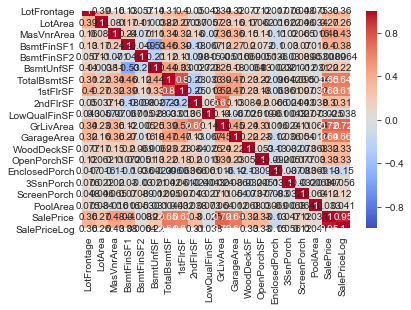

In [10]:
df_corr = train_numeric[features_cont + label].copy()
df_corr['SalePriceLog'] = np.log(df_corr['SalePrice']) 
corr = df_corr.corr()
sns.heatmap(corr, vmin=-1, cmap='coolwarm',annot=True);

features_drop = ['BsmtFinSF2', 'LowQualFinSF', 'PoolArea']

# TODO decide what to do with correlated features below

In [11]:
#sns.scatterplot(x=data_train['TotalBsmtSF'], y=data_train['1stFlrSF']);

class AreaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, floor_area='1stFlrSF'):
        self._floor_area = str(floor_area)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        if self._floor_area == '1stFlrSF':
            df['1st-Bsmt'] =  df['1stFlrSF'] -  df['TotalBsmtSF'] 
            df.drop('TotalBsmtSF', axis=1, inplace=True)             
        if self._floor_area == 'TotalBsmtSF':
            df['1st-Bsmt'] =  df['1stFlrSF'] -  df['TotalBsmtSF']             
            df.drop('1stFlrSF', axis=1, inplace=True)
                  
        return df

In [12]:
#sns.scatterplot(x=data_train['GrLivArea'], y=data_train['1stFlrSF'] + data_train['2ndFlrSF']);

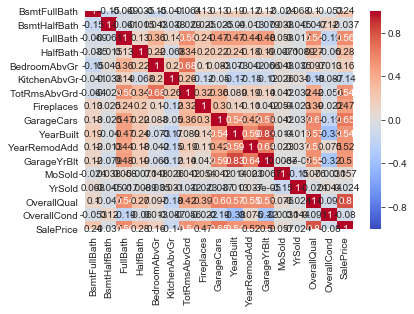

In [13]:
df_corr = train_numeric[features_disc + features_time + features_ord + label].copy()
#df_corr['SalePriceLog'] = np.log(df_corr['SalePrice']) 
corr = df_corr.corr()
sns.heatmap(corr, vmin=-1, cmap='coolwarm',annot=True);

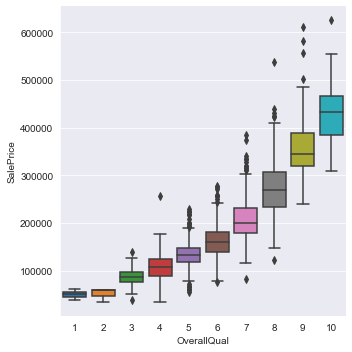

In [14]:
sns.catplot(x='OverallQual', y='SalePrice', data=df_corr, kind='box');

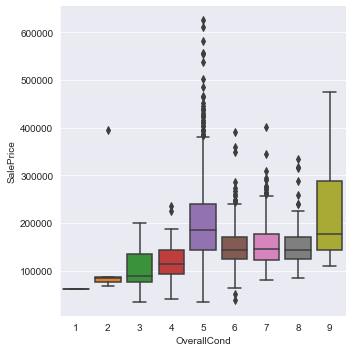

In [15]:
sns.catplot(x='OverallCond', y='SalePrice', data=df_corr, kind='box');

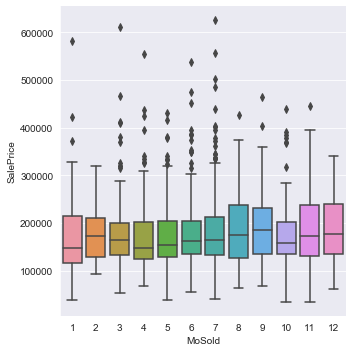

In [16]:
sns.catplot(x='MoSold', y='SalePrice', data=df_corr, kind='box');

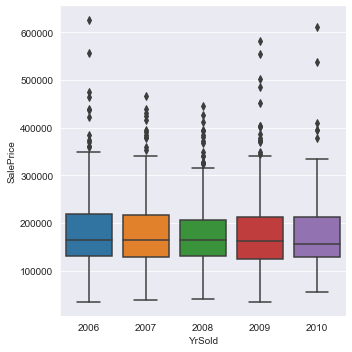

In [17]:
sns.catplot(x='YrSold', y='SalePrice', data=df_corr, kind='box');

## Categorical features

In [18]:
train_cat = data_train.select_dtypes(exclude=[np.number])
train_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [19]:
print(list(train_cat))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


C:\Users\CEDRIC\Anaconda3\envs\keras-tf\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


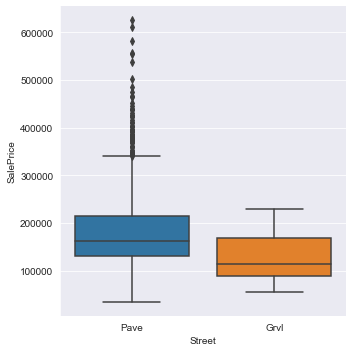

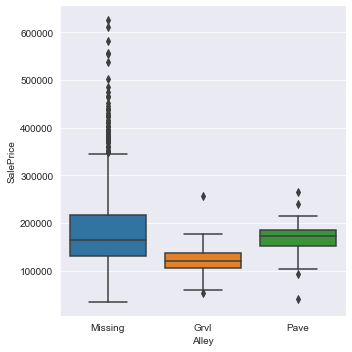

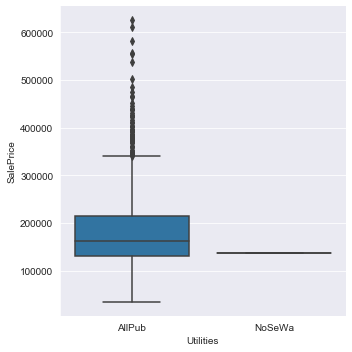

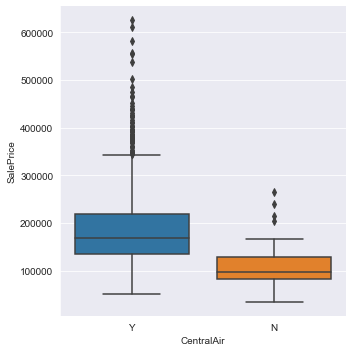

In [20]:
features_bin = ['Street', 'Alley', 'Utilities', 'CentralAir']
features_nom = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 
                'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
                'SaleType', 'SaleCondition']
df = data_train[features_bin + label]
df.fillna(value='Missing', inplace=True)

for col in list(df):
    if col != 'SalePrice':
        sns.catplot(x=col, y='SalePrice', data=df, kind='box');

In [21]:
#
#class BinTransformer(BaseEstimator, TransformerMixin):
#    def __init__(self):
#        pass
    
#    def fit(self, X, y=None):
#        return self
    
#    def transform(self, X, y=None):
#        df = X.copy()
#        df['Street'] = df['Street'].map({'Grvl':0, 'Pave':1})
#        df['CentralAir'] = df['CentralAir'].map({'N':0, 'Y':1})
#        df['Alley'] = df['CentralAir'].map({np.NaN: 1, 'Grvl':0, 'Pave':1})
#        df.drop(['Utilities'], axis=1, inplace=True)
        
#        return df
    
features_drop.append('Utilities')    

In [35]:
def feature_engineering(data):
    df = data.copy()

    # polynomial on total surface to avoid underestimation of higher prices
    df['GrLivArea2'] = df['GrLivArea'].apply(lambda x: x*x)
    
    # binary features
    df['Street'] = df['Street'].map({'Grvl':0, 'Pave':1})
    df['CentralAir'] = df['CentralAir'].map({'N':0, 'Y':1})
    df['Alley'] = df['CentralAir'].map({np.NaN: 1, 'Grvl':0, 'Pave':1})
    
    # ordinal features
    df['ExterQual'] = df['ExterQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['ExterCond'] = df['ExterCond'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['BsmtQual'] = df['BsmtQual'].map({np.NaN:0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['BsmtCond'] = df['BsmtCond'].map({np.NaN:0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['BsmtExposure'] = df['BsmtExposure'].map({np.NaN:0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['HeatingQC'] = df['HeatingQC'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['KitchenQual'] = df['KitchenQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['FireplaceQu'] = df['FireplaceQu'].map({np.NaN:0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['GarageQual'] = df['GarageQual'].map({np.NaN:0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['GarageCond'] = df['GarageCond'].map({np.NaN:0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    df['PoolQC'] = df['PoolQC'].map({np.NaN:0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})    

    # numerical features to code with dummies  
    df = pd.get_dummies(data=df, columns=['OverallCond'])
    
    df = pd.get_dummies(data=df, columns=['MoSold'])
    df = pd.get_dummies(data=df, columns=['Neighborhood'])
    df = pd.get_dummies(data=df, columns=['MSZoning', 'LotConfig', 'Foundation', 'Functional', 'RoofStyle', ])    

    # features to discard
    features_drop = ['LotShape', 'LandContour', 'LandSlope', 'Condition2', 
                'Exterior2nd', 'MasVnrType', 'Condition1', 'BldgType', 'HouseStyle', 'Exterior1st',  
                'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Electrical', 
                'RoofMatl', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 
                'SaleType', 'SaleCondition']
    df.drop(features_drop, axis=1, inplace=True)
    df.drop(['MSSubClass', 'MiscFeature', 'MiscVal'], axis=1, inplace=True)
    df.drop(['Utilities'], axis=1, inplace=True)
    
    # we need to check if target is present before dropping it, otherwise submission set will raise an error
    if 'SalePrice' in list(df):
        df.drop(['SalePrice'], axis=1, inplace=True)
    
    return df

X_fe = feature_engineering(data_train)
X_fe.head()

,LotFrontage,LotArea,Street,Alley,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,YrSold,GrLivArea2,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,1,NaN,7,2003,2003,196.0,4,3,4,3,NaN,706,0,150,856,5,1,856,854,0,1710,1,0,2,1,3,1,4,8,0,0,2003.0,2,548,3,3,0,61,0,0,0,0,0,2008,2924100,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,80.0,9600,1,NaN,6,1976,1976,0.0,3,3,4,3,4.0,978,0,284,1262,5,1,1262,0,0,1262,0,1,2,0,3,1,3,6,1,3,1976.0,2,460,3,3,298,0,0,0,0,0,0,2007,1592644,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,68.0,11250,1,NaN,7,2001,2002,162.0,4,3,4,3,NaN,486,0,434,920,5,1,920,866,0,1786,1,0,2,1,3,1,4,6,1,3,2001.0,2,608,3,3,0,42,0,0,0,0,0,2008,3189796,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4,60.0,9550,1,NaN,7,1915,1970,0.0,3,3,3,4,NaN,216,0,540,756,4,1,961,756,0,1717,1,0,1,0,3,1,4,7,1,4,1998.0,3,642,3,3,0,35,272,0,0,0,0,2006,2948089,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
5,84.0,14260,1,NaN,8,2000,2000,350.0,4,3,4,3,NaN,655,0,490,1145,5,1,1145,1053,0,2198,1,0,2,1,4,1,4,9,1,3,2000.0,3,836,3,3,192,84,0,0,0,0,0,2008,4831204,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


### Linear regression on Log(y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


(1092, 122)
Linear Regression - best parameters: {}
Linear Regression - score on training data = -5688094222626318188544.0000
metric on training set = 0.1014
Linear Regression - score on validation data = 0.9113
metric on training set = 0.1189


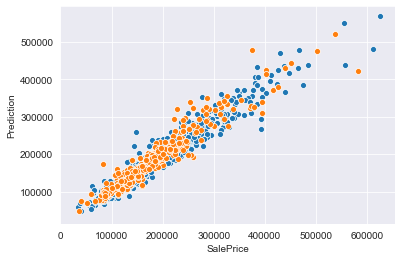

In [36]:
# FIT ON LOG(Y)
X_features = features_cont + features_disc + features_ord + features_bin
#X_train, X_test, y_train, y_test = train_test_split(data_train[X_features], data_train[label], test_size=0.25)
X_train, X_test, y_train, y_test = train_test_split(X_fe, np.log(data_train[label]), test_size=0.25)

model_lr = Pipeline([
#    ('bin', BinTransformer()),
#    ('area', AreaTransformer()),
    ('inputer', SimpleImputer()),
    ('scaler', StandardScaler()),    
    ('lr', LinearRegression()),
    ])

param_lr = {
    }

grid_lr = GridSearchCV(model_lr, param_lr, cv=10, iid=False, verbose=1) #, scoring='neg_mean_squared_log_error')
grid_lr.fit(X_train, y_train);

print(X_train.shape)

print('Linear Regression - best parameters: {}'.format(grid_lr.best_params_))
print('Linear Regression - score on training data = {:.4f}'.format(grid_lr.best_score_))
y_pred = grid_lr.best_estimator_.predict(X_train)
#metric = np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred)))
metric = np.sqrt(mean_squared_error(y_train, y_pred))
print('metric on training set = {:.4f}'.format(metric))

df = y_train.copy()
df['SalePrice'] = np.exp(df['SalePrice'])
df['Prediction'] = np.exp(y_pred)
sns.scatterplot(x='SalePrice', y='Prediction', data=df);

print('Linear Regression - score on validation data = {:.4f}'.format(grid_lr.score(X_test, y_test)))
y_pred = grid_lr.best_estimator_.predict(X_test)
#metric = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred)))
metric = np.sqrt(mean_squared_error(y_test, y_pred))
print('metric on training set = {:.4f}'.format(metric))

df = y_test.copy()
df['SalePrice'] = np.exp(df['SalePrice'])
df['Prediction'] = np.exp(y_pred)
sns.scatterplot(x='SalePrice', y='Prediction', data=df);

## Train model on full dataset

In [37]:
reg = grid_lr.best_estimator_
reg.fit(X_fe, np.log(data_train[label]))

Pipeline(memory=None,
         steps=[('inputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

## Fit test set

In [38]:
X_sub_fe = feature_engineering(data_submission)
y_sub = reg.predict(X_sub_fe)

submission = pd.DataFrame(data=np.exp(y_sub), index=X_sub_fe.index, columns=['SalePrice'])
submission.to_csv('./output/result.csv', 
                columns=['SalePrice'],
                header=True,
                index=True)